In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
%pylab inline

import librosa
import librosa.display
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

Populating the interactive namespace from numpy and matplotlib


In [2]:
# importing labels of the files
labels = os.listdir("Data/")

In [3]:
labels[5]

'03-01-02-01-01-01-06.wav'

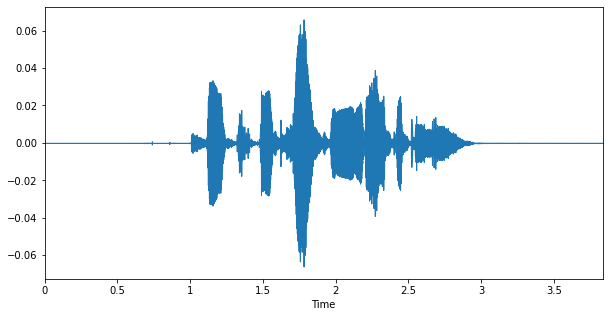

In [4]:
data, sampling_rate = librosa.load(f"Data/{labels[1]}")

plt.figure(figsize=(10,5))
librosa.display.waveplot(data, sr=sampling_rate);

## Extract emotions

In [5]:
emotions = np.array([label.split("-")[2] for label in labels])

In [6]:
emotions[:5]

array(['02', '02', '02', '02', '02'], dtype='<U2')

In [7]:
def extract_features(filename):
    audio, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [8]:
features = []

for label in labels:
    filename = f"Data/{label}"
    
    emotion = label.split("-")[2]
    data = extract_features(filename)
    features.append([data, emotion])

In [9]:
features[1]

[array([-6.66113403e+02,  5.62173576e+01, -7.56887484e+00,  1.57707405e+01,
        -8.45027637e+00,  1.83744097e+00, -6.82167864e+00, -4.37701273e+00,
        -5.91381168e+00,  5.17688990e-01, -5.59894037e+00, -2.13708138e+00,
        -6.38166094e+00,  2.84868383e+00, -6.89996719e+00, -1.23033297e+00,
        -4.16035271e+00, -1.37664831e+00, -4.97348595e+00, -1.35401809e+00,
        -2.00252700e+00, -2.14882398e+00, -1.11055171e+00, -2.46265188e-01,
        -1.22439280e-01,  4.77262735e-01,  4.27485657e+00,  4.82439423e+00,
         7.54139376e+00,  4.93660450e+00,  3.66524744e+00,  3.25066614e+00,
         2.14365625e+00,  3.23849964e+00,  2.43824267e+00,  2.52844048e+00,
        -3.09295207e-01,  9.82488215e-01,  1.01983917e+00,  5.99840820e-01],
       dtype=float32),
 '02']

In [10]:
features_df = pd.DataFrame(features, columns=["feature", "emotion"])

In [11]:
features_df.head()

,feature,emotion
0,"[-729.98016, 66.51589, -0.9419843, 19.070974, ...",02
1,"[-666.1134, 56.217358, -7.568875, 15.7707405, ...",02
2,"[-639.27637, 69.9923, 0.7942198, 17.575535, 1....",02
3,"[-663.54083, 56.19745, -15.152023, 8.111385, -...",02
4,"[-734.74243, 77.852264, 6.6088023, 23.579966, ...",02


In [12]:
### Split the dataset into independent and dependent dataset
X=np.array(features_df['feature'].tolist())
y=np.array(features_df['emotion'].tolist())

In [13]:
X.shape, y.shape

((960, 40), (960,))

In [14]:
y[:10]

array(['02', '02', '02', '02', '02', '02', '02', '02', '02', '02'],
      dtype='<U2')

In [15]:
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [16]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [17]:
### Train Test Split
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [18]:
X_train

array([[-6.9474713e+02,  5.5160381e+01, -2.5127358e+00, ...,
        -7.3903787e-01, -1.9837615e+00, -1.2665052e+00],
       [-8.0673053e+02,  4.5237591e+01, -5.5813923e+00, ...,
         2.7756355e+00,  5.9816724e-01,  5.2687460e-01],
       [-6.1684766e+02,  8.1195053e+01, -6.6228852e+00, ...,
         2.4592552e+00, -1.2701117e+00, -6.9109130e-01],
       ...,
       [-5.8245581e+02,  4.5947723e+01, -2.5991879e+01, ...,
        -7.8162730e-01,  1.3410363e+00,  1.9998642e+00],
       [-6.3795978e+02,  7.1686310e+01, -6.8877344e+00, ...,
         4.0222698e-01, -1.3108990e+00,  5.2045202e-01],
       [-3.6642828e+02,  2.3118233e+01, -1.6935003e+01, ...,
         2.2547913e-01,  1.0447268e+00,  3.1393673e+00]], dtype=float32)

In [19]:
y_train

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((768, 40), (768, 5), (192, 40), (192, 5))

## Model Creation

In [21]:
### No of classes
num_labels=y.shape[1]

In [22]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [24]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [25]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='./saveModel/audio_classification2.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


Epoch 1/100
 1/24 [>.............................] - ETA: 26s - loss: 150.9099 - accuracy: 0.1250
Epoch 00001: val_loss improved from inf to 7.72853, saving model to ./saveModel\audio_classification2.hdf5
24/24 [==============================] - 2s 16ms/step - loss: 71.0830 - accuracy: 0.2031 - val_loss: 7.7285 - val_accuracy: 0.2656
Epoch 2/100
 1/24 [>.............................] - ETA: 0s - loss: 46.2728 - accuracy: 0.3125
Epoch 00002: val_loss improved from 7.72853 to 2.82045, saving model to ./saveModel\audio_classification2.hdf5
24/24 [==============================] - 0s 8ms/step - loss: 34.6958 - accuracy: 0.2005 - val_loss: 2.8204 - val_accuracy: 0.2500
Epoch 3/100
 1/24 [>.............................] - ETA: 0s - loss: 16.5913 - accuracy: 0.3125
Epoch 00003: val_loss improved from 2.82045 to 1.66425, saving model to ./saveModel\audio_classification2.hdf5
24/24 [==============================] - 0s 5ms/step - loss: 20.5658 - accuracy: 0.2083 - val_loss: 1.6643 - val_accurac

Epoch 30/100
 1/24 [>.............................] - ETA: 0s - loss: 1.6332 - accuracy: 0.2500
Epoch 00030: val_loss did not improve from 1.60686
24/24 [==============================] - 0s 2ms/step - loss: 1.6768 - accuracy: 0.1914 - val_loss: 1.6110 - val_accuracy: 0.2135
Epoch 31/100
 1/24 [>.............................] - ETA: 0s - loss: 1.6283 - accuracy: 0.1562
Epoch 00031: val_loss did not improve from 1.60686
24/24 [==============================] - 0s 2ms/step - loss: 1.6849 - accuracy: 0.1758 - val_loss: 1.6114 - val_accuracy: 0.1406
Epoch 32/100
 1/24 [>.............................] - ETA: 0s - loss: 1.6113 - accuracy: 0.2812
Epoch 00032: val_loss did not improve from 1.60686
24/24 [==============================] - 0s 2ms/step - loss: 1.6626 - accuracy: 0.2161 - val_loss: 1.6115 - val_accuracy: 0.1406
Epoch 33/100
 1/24 [>.............................] - ETA: 0s - loss: 1.6408 - accuracy: 0.2500
Epoch 00033: val_loss did not improve from 1.60686
24/24 [==================

Epoch 60/100
17/24 [====================>.........] - ETA: 0s - loss: 1.6359 - accuracy: 0.2188
Epoch 00060: val_loss did not improve from 1.60686
24/24 [==============================] - 0s 4ms/step - loss: 1.6245 - accuracy: 0.2161 - val_loss: 1.6157 - val_accuracy: 0.1406
Epoch 61/100
 1/24 [>.............................] - ETA: 0s - loss: 1.6042 - accuracy: 0.2500
Epoch 00061: val_loss did not improve from 1.60686
24/24 [==============================] - 0s 2ms/step - loss: 1.6062 - accuracy: 0.2122 - val_loss: 1.6158 - val_accuracy: 0.1406
Epoch 62/100
 1/24 [>.............................] - ETA: 0s - loss: 1.9954 - accuracy: 0.3438
Epoch 00062: val_loss did not improve from 1.60686
24/24 [==============================] - 0s 3ms/step - loss: 1.6487 - accuracy: 0.2122 - val_loss: 1.6160 - val_accuracy: 0.1406
Epoch 63/100
 1/24 [>.............................] - ETA: 0s - loss: 1.5860 - accuracy: 0.2500
Epoch 00063: val_loss did not improve from 1.60686
24/24 [==================

Epoch 90/100
 1/24 [>.............................] - ETA: 0s - loss: 1.6123 - accuracy: 0.1250
Epoch 00090: val_loss did not improve from 1.60686
24/24 [==============================] - 0s 2ms/step - loss: 1.6237 - accuracy: 0.2135 - val_loss: 1.6165 - val_accuracy: 0.1406
Epoch 91/100
 1/24 [>.............................] - ETA: 0s - loss: 1.6110 - accuracy: 0.2188
Epoch 00091: val_loss did not improve from 1.60686
24/24 [==============================] - 0s 2ms/step - loss: 1.6094 - accuracy: 0.2122 - val_loss: 1.6163 - val_accuracy: 0.1406
Epoch 92/100
 1/24 [>.............................] - ETA: 0s - loss: 1.6029 - accuracy: 0.2812
Epoch 00092: val_loss did not improve from 1.60686
24/24 [==============================] - 0s 3ms/step - loss: 1.6263 - accuracy: 0.2148 - val_loss: 1.6167 - val_accuracy: 0.1406
Epoch 93/100
24/24 [==============================] - ETA: 0s - loss: 1.6176 - accuracy: 0.2161
Epoch 00093: val_loss did not improve from 1.60686
24/24 [==================

In [26]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
test_accuracy[1]

0.140625

In [31]:
model_imported = tf.keras.models.load_model("savedModel/audio_classification2.hdf5")

test_accuracy=model_imported.evaluate(X_test,y_test,verbose=0)
test_accuracy[1]

0.640625

In [32]:
model_imported2 = tf.keras.models.load_model("savedModel/audio_classification.hdf5")

test_accuracy=model_imported2.evaluate(X_test,y_test,verbose=0)
test_accuracy[1]

0.9010416865348816

In [33]:
accuracy = test_accuracy[1]

In [35]:
# Accuracy in percentage
accuracy * 100

90.10416865348816